In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import random
#tf.compat.v1.enable_eager_execution(
 #   config=None, device_policy=None, execution_mode=None
#)

In [2]:
# seed must be equal for both training and validation not to overlap.
BATCH_SIZE = 32
IMG_SIZE = (160, 160)  # resolution
directory = "Dataset/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             label_mode='categorical',
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.
Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [3]:
class_names = train_dataset.class_names
class_names



['Density1Benign',
 'Density1Malignant',
 'Density2Benign',
 'Density2Malignant',
 'Density3Benign',
 'Density3Malignant',
 'Density4Benign',
 'Density4Malignant']

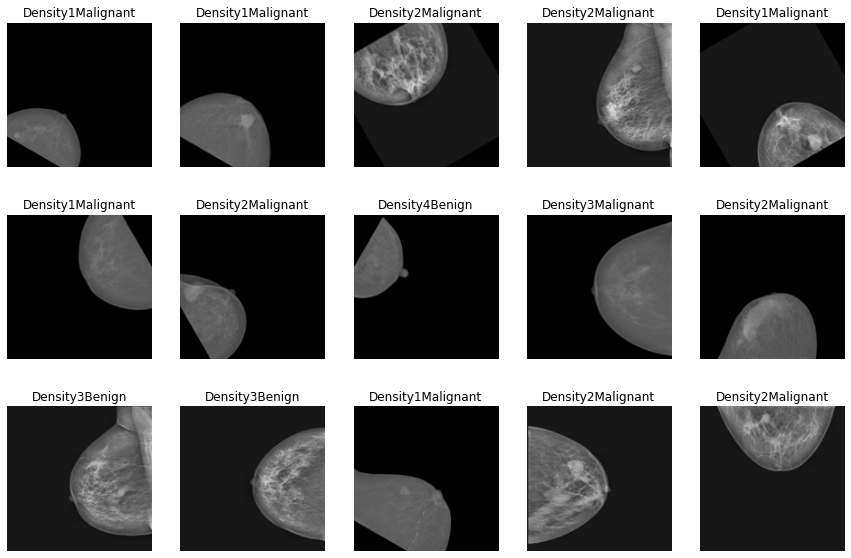

In [10]:
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        lbl = labels[i].numpy()
        index = np.where(lbl ==1)
        index = index[0][0]
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[index])
        plt.axis("off")

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# prevents a memory bottleneck that can occur when reading from disk

In [12]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

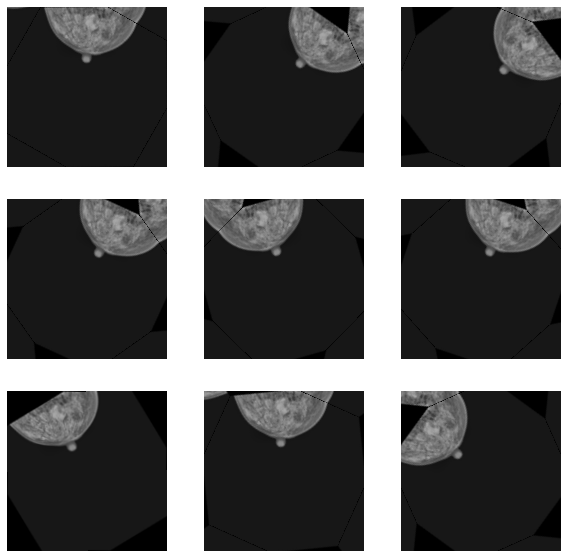

In [13]:
#preview first image augmentations
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/ 255)  # 0-1 float or 0-255 integer values
        plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input #data preprocessing using the same weights the model was trained on

In [15]:
# MobileNet V2 trained on imagenet data
IMG_SHAPE = IMG_SIZE + (3,) # as Img size 160*160 only but we need it 160*160*3 for the model
base_model = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [8]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

post_bn
post_relu


In [50]:
# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(32, 1000)


In [51]:
label_batch  # actual labels for those 32 image in first batch

<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [

In [9]:
# Create the breast cancer model
def BC_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # Create the model with its weights without the top layers
     
    base_model.trainable = False  # not to train any of the base model and train only the new layers will be added
    inputs = tf.keras.Input(shape=input_shape)
    
    #x = data_augmentation(inputs) # augmenting the input
    
    x = preprocess_input(inputs) #data preprocessing using the same weights the model was trained on
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.25)(x)
    prediction_layer = tfl.Dense(8, activation='softmax') 
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    print(model.summary())
    return model
    

In [10]:
BCModel = BC_model(IMG_SIZE)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                

In [11]:
base_learning_rate = 0.01
BCModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
initial_epochs = 5
history = BCModel.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, use_multiprocessing= True)


Epoch 1/5
 26/191 [===>..........................] - ETA: 4:26 - loss: 1.3183 - accuracy: 0.7440

KeyboardInterrupt: 

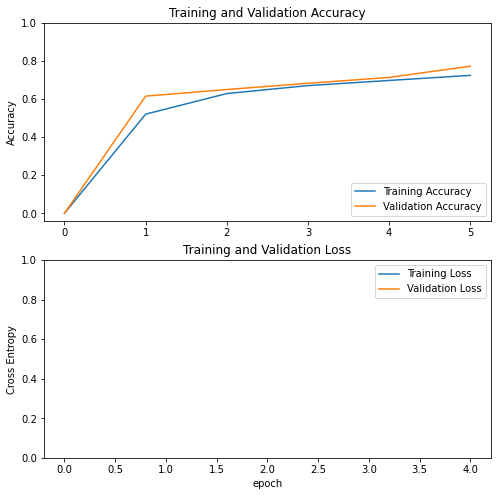

In [14]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
# Make it trainable from specified layer number
base_model.trainable = True # Make all trainable as a start
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  377


In [19]:
fine_tune_at = 350 # Number to choose

for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= 'categorical_crossentropy'
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

BCModel.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [20]:
BCModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                

In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = BCModel.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
 95/191 [=============>................] - ETA: 2:50 - loss: 0.8991 - accuracy: 0.7921

KeyboardInterrupt: 

In [61]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

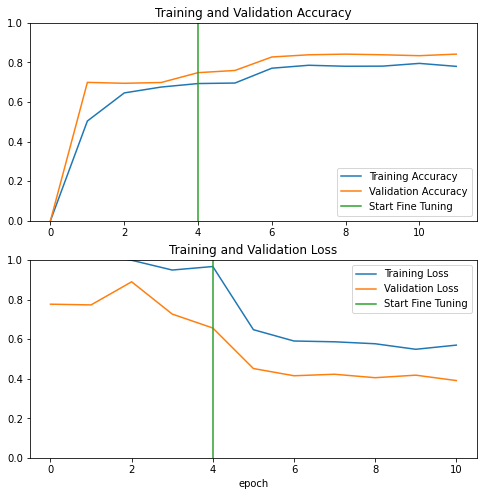

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [67]:
BCModel.evaluate(validation_dataset)

48/48 [==============================] - 16s 338ms/step - loss: 0.3908 - accuracy: 0.8421


[0.39081305265426636, 0.8420707583427429]

In [69]:
BCModel.evaluate(train_dataset)

191/191 [==============================] - 66s 344ms/step - loss: 0.2614 - accuracy: 0.9145


[0.2614166736602783, 0.9145103096961975]

In [75]:
BCModel

{'loss': [0.6481223702430725,
  0.5908203721046448,
  0.5868381261825562,
  0.5769368410110474,
  0.5489449501037598,
  0.5700268149375916],
 'accuracy': [0.7708811163902283,
  0.7857844829559326,
  0.7807074785232544,
  0.7813625931739807,
  0.795283317565918,
  0.7802161574363708],
 'val_loss': [0.4516216814517975,
  0.41504359245300293,
  0.42265719175338745,
  0.4052271544933319,
  0.4180185794830322,
  0.39081305265426636],
 'val_accuracy': [0.8276540040969849,
  0.8387942314147949,
  0.8420707583427429,
  0.8387942314147949,
  0.8342070579528809,
  0.8420707583427429]}

In [93]:
reconstructed_model.save("MultiClassModelBreatCancerResNet")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MultiClassModelBreatCancerResNet\assets


The truth ground class is Density3Malignant
The predicted class is Density3Malignant


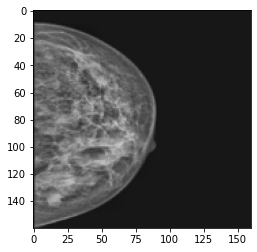

In [65]:
for imgs,labels in validation_dataset.take(1):
    plt.imshow(imgs[11].numpy().astype("uint8"))
    detect = list(labels[11].numpy())
    print('The truth ground class is ' + class_names[detect.index(max(detect))])
    img = tf.keras.preprocessing.image.img_to_array(imgs[11])
    img = np.expand_dims(img, axis = 0)
    predict = reconstructed_model.predict(img)
    predict = list(predict[0])
    print('The predicted class is ' + class_names[predict.index(max(predict))])

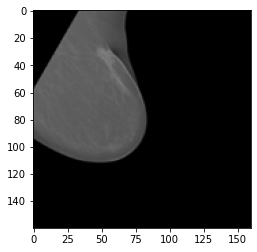

In [117]:
plt.imshow(imgs[1].numpy().astype("uint8"))

In [66]:
reconstructed_model = tf.keras.models.load_model("MultiClassModel")

In [39]:
reconstructed_model.evaluate(validation_dataset)

48/48 [==============================] - 43s 891ms/step - loss: 0.3908 - accuracy: 0.8421


[0.3908131420612335, 0.8420707583427429]

In [68]:
img_width, img_height = 160, 160
img = tf.keras.preprocessing.image.load_img('22580192 (26).png', target_size = (img_width, img_height))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

reconstructed_model.predict(img)


array([[1.2057822e-05, 3.6341690e-02, 9.6363419e-01, 5.2765313e-06,
        3.1746109e-07, 6.3954872e-06, 2.5428882e-16, 8.0636513e-20]],
      dtype=float32)

In [94]:
converter = tf.lite.TFLiteConverter.from_saved_model("MultiClassModelBreatCancerResNet")
tflite_model = converter.convert()


In [95]:
# Save the model.
with open('BreastCancerMultiClassResNet.tflite', 'wb') as f:
    f.write(tflite_model)

In [89]:
def predict_image(img_path):
    img_width, img_height = 160, 160
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)

    probs = list(reconstructed_model.predict(img)[0])
    prob = max(probs)
    indx = probs.index(prob)
    print('The predicted class is ' + class_names[indx])
    predicted_class_name = class_names[indx]
    return predicted_class_name, prob 
    

In [78]:
list(reconstructed_model.predict(img)[0])

[1.2057822e-05,
 0.03634169,
 0.9636342,
 5.2765313e-06,
 3.174611e-07,
 6.395487e-06,
 2.5428882e-16,
 8.063651e-20]

In [91]:
predict_image('20587902 (40).png')

The predicted class is Density4Benign


('Density4Benign', 0.9923698)